In [304]:
#put all the imports here
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [305]:
file_path = '/content/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path)
df.drop(columns=['Person ID'], inplace=True)
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


# Data Preprocessing



In [306]:
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['Gender', 'Occupation', 'BMI Category', 'Blood Pressure',
       'Sleep Disorder'],
      dtype='object')

In [307]:
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

def categorize_bp(row):
    systolic = row['Systolic_BP']
    diastolic = row['Diastolic_BP']
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif systolic >= 130 or diastolic >= 80:
        return 'Hypertension'
    return 'Unknown'

df['BP_Category'] = df.apply(categorize_bp, axis=1)
df.drop(columns=['Blood Pressure'], inplace=True)

In [308]:
df_original = df.copy()
label_encoder = LabelEncoder()

columns_to_encode = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder', 'BP_Category']

unique_mappings = {}

for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])
    unique_mappings[column] = pd.DataFrame({
        'Original': label_encoder.classes_,
        'Encoded': range(len(label_encoder.classes_))
    })

for column, mapping in unique_mappings.items():
    print(f"\nUnique values for '{column}':")
    print(mapping)

print("\nDataFrame after encoding:")
df.head()


Unique values for 'Gender':
  Original  Encoded
0   Female        0
1     Male        1

Unique values for 'Occupation':
                Original  Encoded
0             Accountant        0
1                 Doctor        1
2               Engineer        2
3                 Lawyer        3
4                Manager        4
5                  Nurse        5
6   Sales Representative        6
7            Salesperson        7
8              Scientist        8
9      Software Engineer        9
10               Teacher       10

Unique values for 'BMI Category':
        Original  Encoded
0         Normal        0
1  Normal Weight        1
2          Obese        2
3     Overweight        3

Unique values for 'Sleep Disorder':
      Original  Encoded
0     Insomnia        0
1  Sleep Apnea        1
2          NaN        2

Unique values for 'BP_Category':
       Original  Encoded
0      Elevated        0
1  Hypertension        1
2        Normal        2

DataFrame after encoding:


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP,BP_Category
0,1,27,9,6.1,6,42,6,3,77,4200,2,126,83,1
1,1,28,1,6.2,6,60,8,0,75,10000,2,125,80,1
2,1,28,1,6.2,6,60,8,0,75,10000,2,125,80,1
3,1,28,6,5.9,4,30,8,2,85,3000,1,140,90,1
4,1,28,6,5.9,4,30,8,2,85,3000,1,140,90,1


# Exploratory Data Analysis



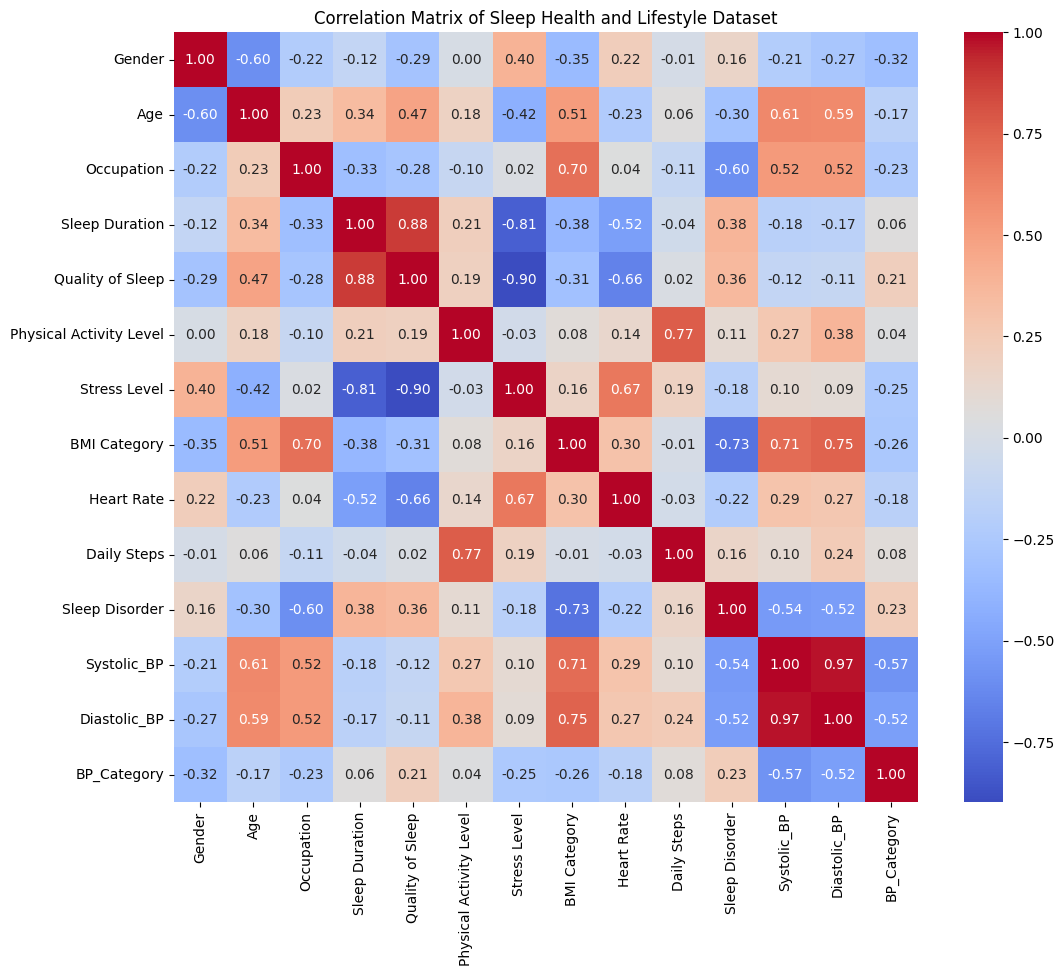


Correlation with 'Sleep Disorder':


,Sleep Disorder
Sleep Disorder,1.000000
Sleep Duration,0.382045
Quality of Sleep,0.357477
BP_Category,0.228260
Daily Steps,0.161275
Gender,0.161131
Physical Activity Level,0.109225
Stress Level,-0.181296
Heart Rate,-0.220913
Age,-0.303962


In [309]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sleep Health and Lifestyle Dataset')
plt.show()

correlation_with_sleep_disorder = correlation_matrix['Sleep Disorder'].sort_values(ascending=False)
print("\nCorrelation with 'Sleep Disorder':")
correlation_with_sleep_disorder

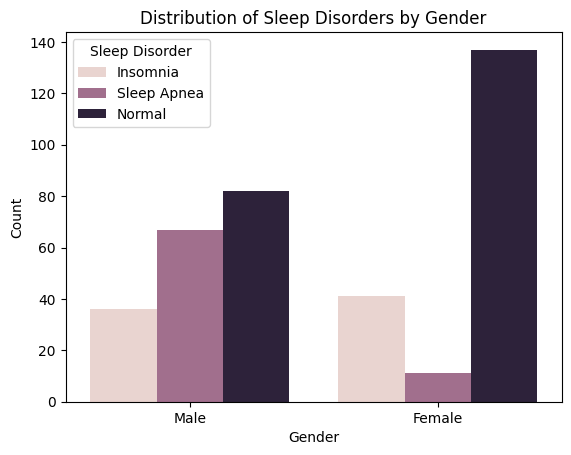

In [310]:
sns.countplot(x='Gender', hue='Sleep Disorder', data=df)
plt.title("Distribution of Sleep Disorders by Gender")
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.xlabel("Gender")
plt.ylabel("Count")

plt.legend(
    title="Sleep Disorder",
    labels=['Insomnia', 'Sleep Apnea', 'Normal'],
    loc='upper left',
    fontsize=10
)

plt.show()

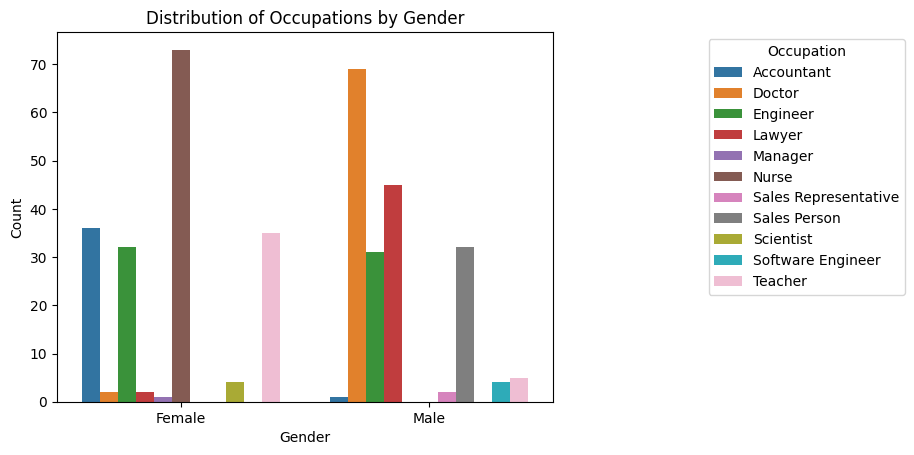

In [311]:
gender_order = [1,0]
occupation_order = ['Accountant', 'Doctor', 'Engineer', 'Lawyer', 'Manager', 'Nurse', 'Sales Representative', 'Sales Person', 'Scientist', 'Software Engineer', 'Teacher']
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#f7b6d2'
]

sns.countplot(
    x='Gender',
    hue='Occupation',
    data=df,
    palette=custom_palette
)

plt.title("Distribution of Occupations by Gender")
plt.xticks(ticks=[1,0], labels=['Male', 'Female'])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(
    title="Occupation",
    labels=occupation_order,
    bbox_to_anchor=(1.3, 1),
    loc='upper left',
    fontsize=10
)
plt.show()

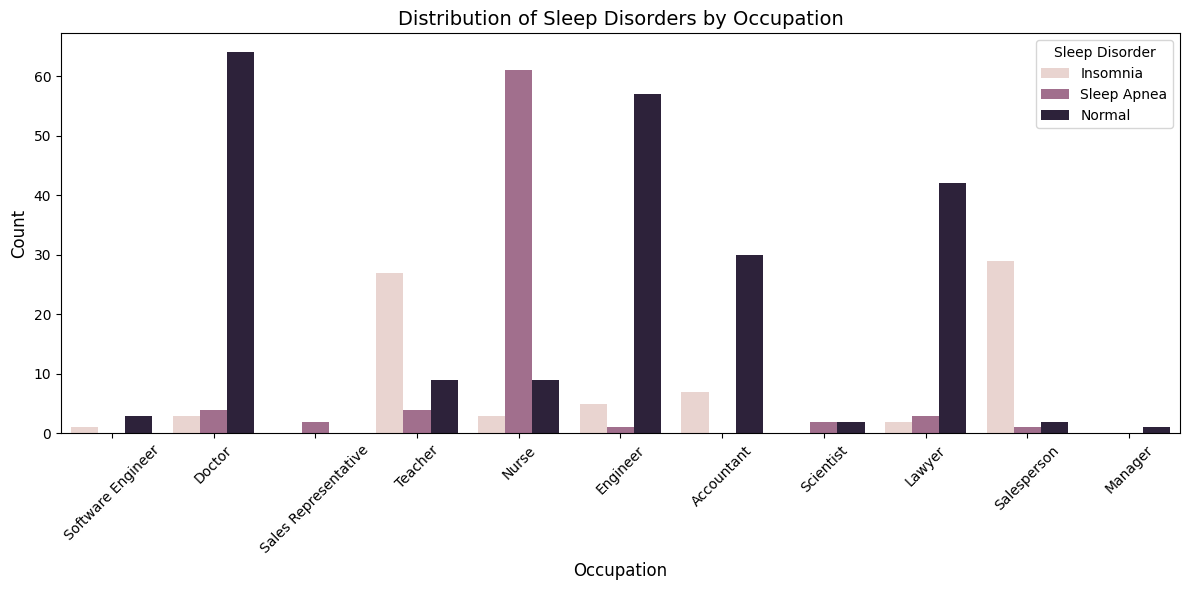

In [312]:
occupation_mapping = {
    0: 'Accountant',
    1: 'Doctor',
    2: 'Engineer',
    3: 'Lawyer',
    4: 'Manager',
    5: 'Nurse',
    6: 'Sales Representative',
    7: 'Salesperson',
    8: 'Scientist',
    9: 'Software Engineer',
    10: 'Teacher'
}

df['Occupation'] = df['Occupation'].map(occupation_mapping)

unmapped = df[df['Occupation'].isnull()]['Occupation'].unique()
if len(unmapped) > 0:
    print(f"Unmapped occupation codes found: {unmapped}")
    df['Occupation'] = df['Occupation'].fillna('Unknown')

plt.figure(figsize=(12, 6))
sns.countplot(x='Occupation', hue='Sleep Disorder', data=df)
plt.title("Distribution of Sleep Disorders by Occupation", fontsize=14)
plt.xlabel("Occupation", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

plt.legend(
    title="Sleep Disorder",
    labels=['Insomnia', 'Sleep Apnea', 'Normal'],
    loc='upper right',
    fontsize=10
)

plt.tight_layout()
plt.show()

# Training Model

Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

    Insomnia       1.00      0.67      0.80         9
        None       0.72      0.93      0.81        14
 Sleep Apnea       0.92      0.85      0.88        13

    accuracy                           0.83        36
   macro avg       0.88      0.81      0.83        36
weighted avg       0.86      0.83      0.83        36



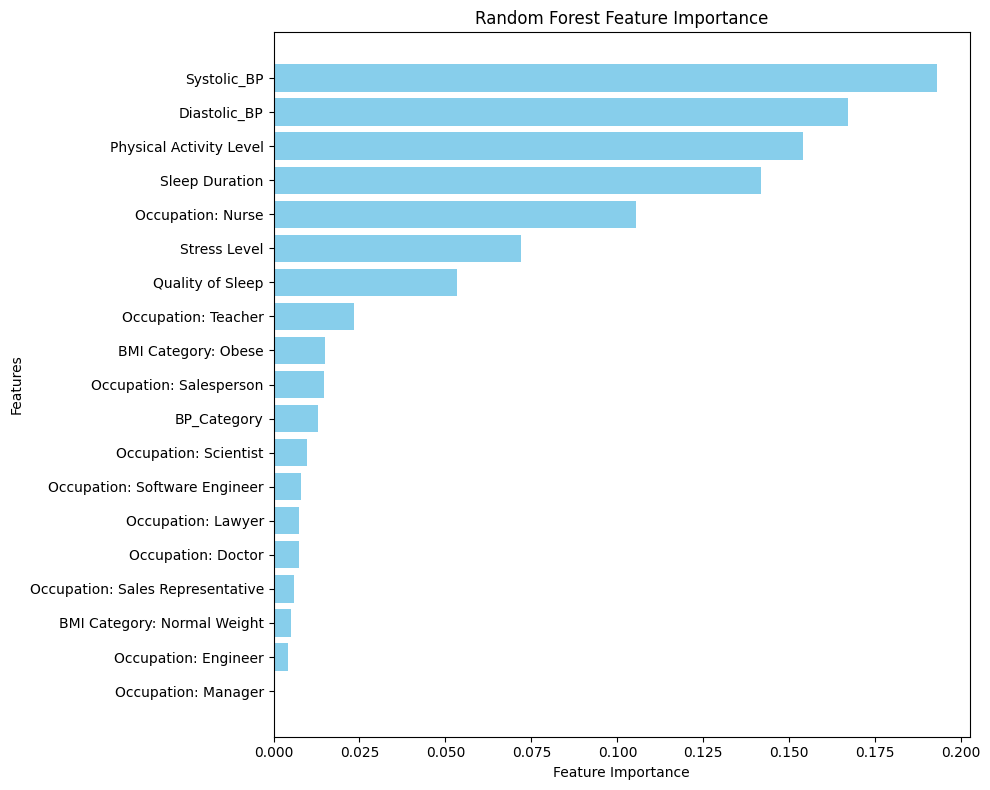

In [313]:
features = ['Occupation', 'Sleep Duration', 'Quality of Sleep', 'BMI Category', 'Stress Level']
target = 'Sleep Disorder'

df = df.dropna(subset=features + [target])

class_mapping = {0: "None", 1: "Sleep Apnea", 2: "Insomnia"}

occupation_mapping = {
    1: 'Accountant',
    2: 'Doctor',
    3: 'Engineer',
    4: 'Lawyer',
    5: 'Manager',
    6: 'Nurse',
    7: 'Sales Representative',
    8: 'Salesperson',
    9: 'Scientist',
    10: 'Software Engineer',
    11: 'Teacher'
}

if pd.api.types.is_numeric_dtype(df['Occupation']):
    df['Occupation'] = df['Occupation'].map(occupation_mapping)
    if df['Occupation'].isnull().any():
        unmapped = df[df['Occupation'].isnull()]['Occupation'].unique()
        print(f"Warning: The following occupation codes are unmapped and will be dropped: {unmapped}")
        df = df.dropna(subset=['Occupation'])

bmi_mapping = {
    1: 'Normal',
    2: 'Normal Weight',
    3: 'Obese',
    4: 'Overweight'
}

if pd.api.types.is_numeric_dtype(df['BMI Category']):
    df['BMI Category'] = df['BMI Category'].map(bmi_mapping)
    if df['BMI Category'].isnull().any():
        unmapped = df[df['BMI Category'].isnull()]['BMI Category'].unique()
        print(f"Warning: The following BMI category codes are unmapped and will be dropped: {unmapped}")
        df = df.dropna(subset=['BMI Category'])

df = pd.get_dummies(df, columns=['Occupation', 'BMI Category'], drop_first=True)

X = df.drop(columns=['Person ID', 'Gender', 'Age', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder'], errors='ignore')
y = df['Sleep Disorder']

y_encoded = y.map(class_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

importances = rf_model.feature_importances_
feature_names = X.columns

feature_names = feature_names.str.replace("Occupation_", "Occupation: ")
feature_names = feature_names.str.replace("BMI Category_", "BMI Category: ")

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters from GridSearchCV: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation Accuracy Scores: [0.91666667 0.94444444 0.91666667 0.83333333 0.88571429]
Mean CV Accuracy: 0.8994 ± 0.0379

Cross-Validated Classification Report:
               precision    recall  f1-score   support

    Insomnia       1.00      0.75      0.86        36
        None       0.87      0.96      0.91        70
 Sleep Apnea       0.89      0.92      0.91        73

    accuracy                           0.90       179
   macro avg       0.92      0.87      0.89       179
weighted avg       0.91      0.90      0.90       179



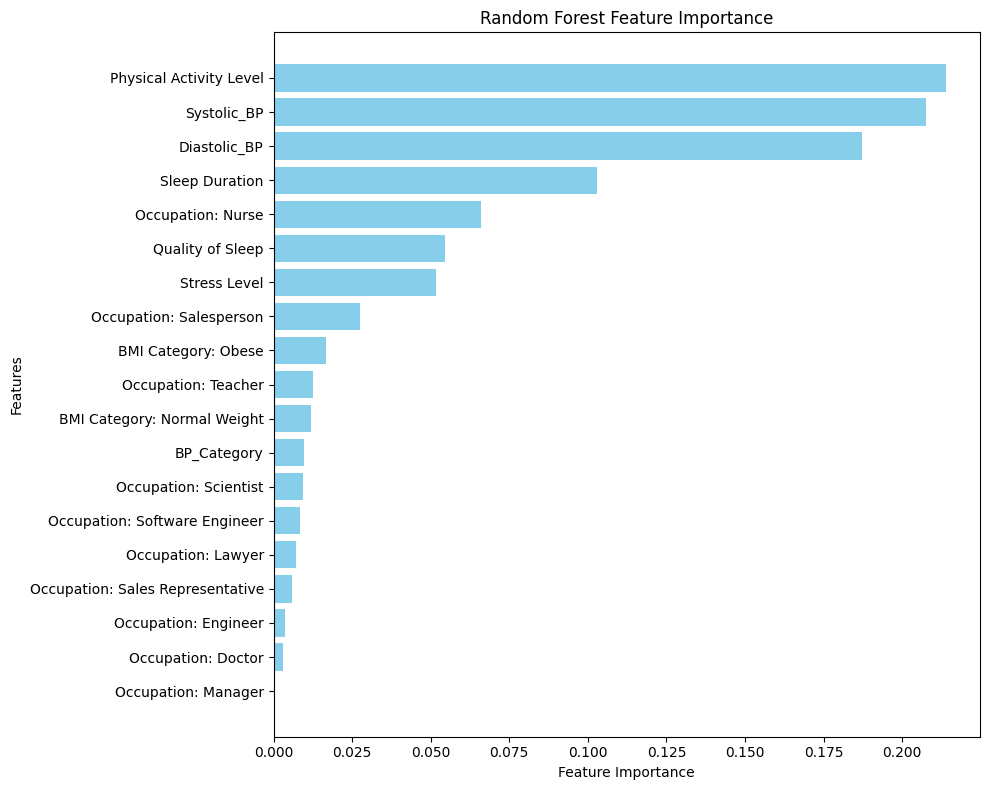

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_num = le.fit_transform(y_encoded)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)

grid_search.fit(X, y_num)

print("Best parameters from GridSearchCV:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

cv_scores = cross_val_score(best_rf, X, y_num, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

y_pred_cv = cross_val_predict(best_rf, X, y_num, cv=cv)

y_pred_cv_labels = le.inverse_transform(y_pred_cv)
y_true_labels = le.inverse_transform(y_num)

report = classification_report(y_true_labels, y_pred_cv_labels)
print("\nCross-Validated Classification Report:\n", report)

best_rf.fit(X, y_num)
importances = best_rf.feature_importances_
feature_names = X.columns

feature_names = feature_names.str.replace("Occupation_", "Occupation: ")
feature_names = feature_names.str.replace("BMI Category_", "BMI Category: ")

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()